In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Let's go for exploration

In [53]:

import pandas as pd
import numpy as np

# Correct file path (CSV file inside the folder)
csv_path = "/kaggle/input/air-quality-prediction/AirQuality.csv"

# Load dataset
df = pd.read_csv(csv_path, sep=';', decimal=',', encoding='latin1')

# Drop unnamed columns (caused by extra ; at end of file)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Replace invalid values (-200) with NaN
df = df.replace(-200, np.nan)

# ---- Fill Missing Values ----
# Numeric columns: fill with column mean
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mean())

# Date & Time columns: drop rows with missing
df = df.dropna(subset=['Date', 'Time'])

# Reset index after cleaning
df = df.reset_index(drop=True)

# Show quick info
print(" Cleaned Dataset Info:")
print(df.info())

print("\n Preview of Data:")
print(df.head())

print("\n Summary Statistics (after filling missing):")
print(df.describe())


 Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB
None

 Preview of Data:
         Date      Time  CO(GT)  PT08.S1(CO) 

so we cleaned the data

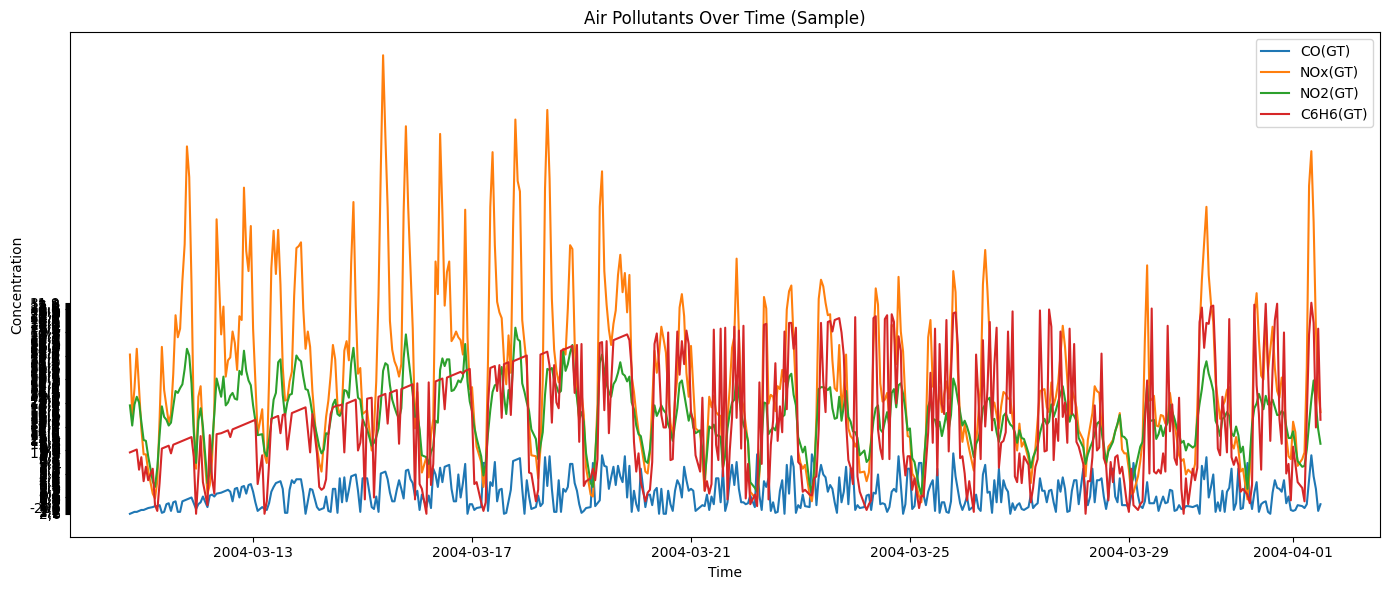

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with proper formatting
df = pd.read_csv("/kaggle/input/air-quality-prediction/AirQuality.csv", sep=';', encoding='latin1')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Remove weird extra columns
df.replace(-200, pd.NA, inplace=True)  # Treat -200 as missing data

# Clean up the datetime column
df = df.dropna(subset=['Date', 'Time'])  # Drop rows missing date/time
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df = df.dropna(subset=['Datetime'])  # Drop rows where datetime failed
df.set_index('Datetime', inplace=True)

# Pick a few key pollutants to explore
pollutants = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
sample_df = df[pollutants].dropna().iloc[:500]  # Use a small sample to keep things fast

# Plot time series
plt.figure(figsize=(14, 6))
for pollutant in pollutants:
    plt.plot(sample_df.index, sample_df[pollutant], label=pollutant)
plt.title("Air Pollutants Over Time (Sample)")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.tight_layout()
plt.show()


regression model


🔍 Predicting CO(GT)...
R² Score: 0.012
RMSE: 48.55


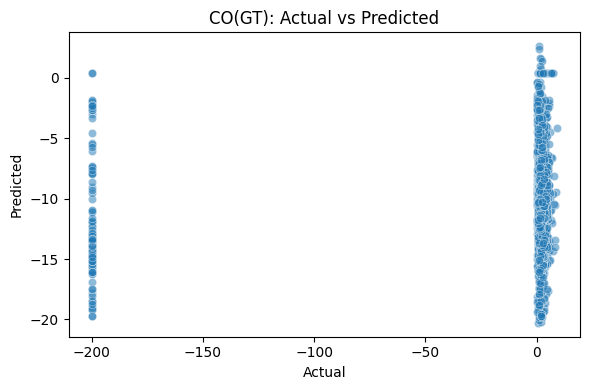


🔍 Predicting NOx(GT)...
R² Score: 0.085
RMSE: 198.12


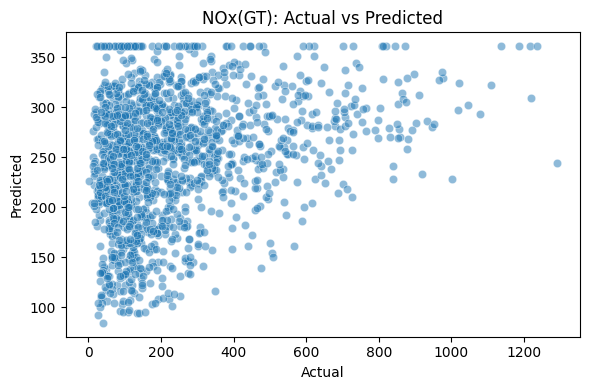


🔍 Predicting NO2(GT)...
R² Score: 0.090
RMSE: 44.56


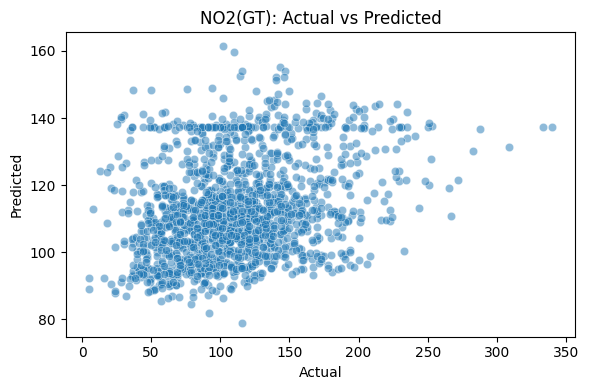


🔍 Predicting C6H6(GT)...
R² Score: 0.977
RMSE: 6.62


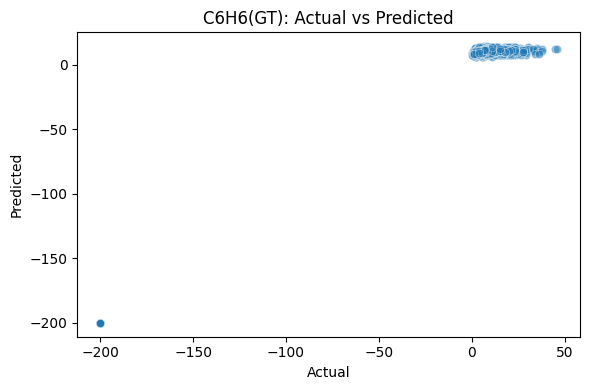

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load and clean the dataset
df = pd.read_csv("/kaggle/input/air-quality-prediction/AirQuality.csv", sep=';', encoding='latin1')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.replace(-200, pd.NA, inplace=True)
df = df.dropna(subset=['Date', 'Time'])
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df = df.dropna(subset=['Datetime'])
df.set_index('Datetime', inplace=True)

# Select features and target pollutants
features = ['T', 'RH', 'AH']
pollutants = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']

# Fix comma decimals and convert to float
for col in features + pollutants:
    df[col] = df[col].astype(str).str.replace(',', '.')
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values in selected columns
df_model = df[features + pollutants].dropna()

# Train and evaluate model for each pollutant
for pollutant in pollutants:
    print(f"\n🔍 Predicting {pollutant}...")
    
    X = df_model[features]
    y = df_model[pollutant]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.2f}")
    
    # Plot predicted vs actual
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{pollutant}: Actual vs Predicted")
    plt.tight_layout()
    plt.show()


Random Forest Regression


Feature Importance:
  Feature  Importance
2      AH    0.385644
1      RH    0.358771
0       T    0.255585


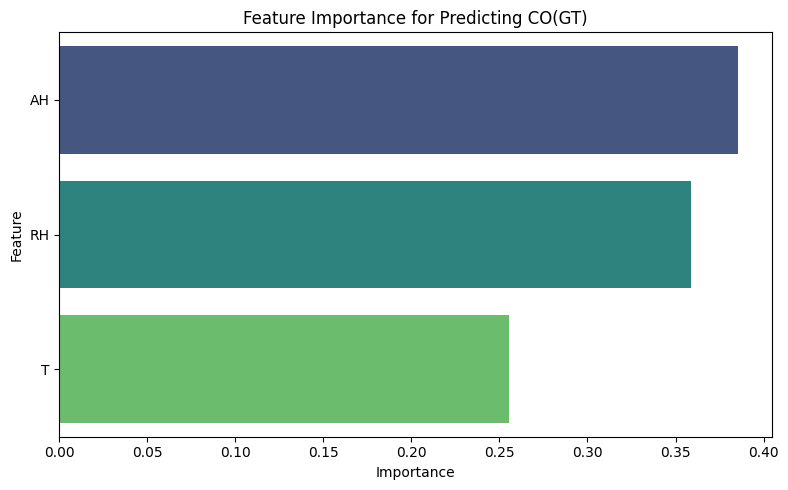

Predicting CO(GT)
R² Score: -0.135
RMSE: 51.16


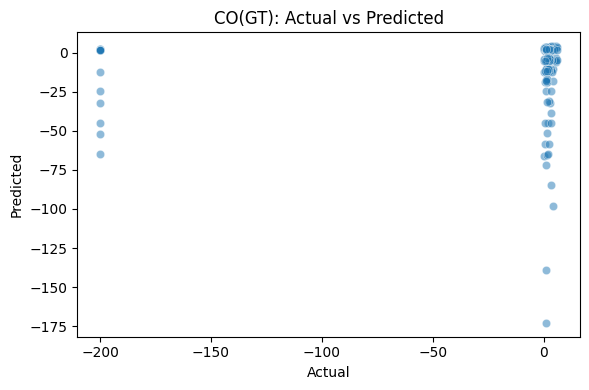

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Use a smaller sample of the cleaned dataset
df_sample = df_model.sample(n=1000, random_state=42)

# Choose one pollutant to predict
target = 'CO(GT)'
X = df_sample[features]
y = df_sample[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest with fewer trees
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Show feature importance
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title(f"Feature Importance for Predicting {target}")
plt.tight_layout()
plt.show()

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Predicting {target}")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"{target}: Actual vs Predicted")
plt.tight_layout()
plt.show()
